In this notebook I 
- explain why optimization using Optim might be problematic when a function has several local minima/maxima,
- and show how one can get around this problem using brute force.

# The problem of several local extrema

As an example consider
$$f(x, y) = -cos(x^2 + y^2) / (1 + x^2 + y^2)$$
which is plotted below. (If you do not get the code that produces the figure, don't worry. This is not the point here.)

This function has a global minimum at (0,0) but there are other local minima as well.


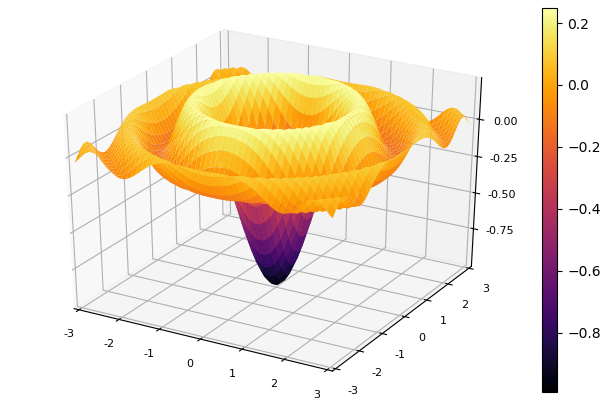

In [1]:
using Plots
Plots.pyplot()

n = 50
x = linspace(-3, 3, n)
y = x

z = Array{Float64}(n, n)
ff(x, y) = -cos(x^2 + y^2) / (1 + x^2 + y^2)
for i in 1:n
    for j in 1:n
        z[j, i] = ff(x[i], y[j])
    end
end

Plots.surface(x, y, z')

What happens if we use Optim to find the minimum of the function? Let us first do so with a starting value close to the actual minimum:

In [5]:
using Optim

f(x)=-cos(x[1]^2 + x[2]^2) / (1 + x[1]^2 + x[2]^2)
optimize(f,[1.0,1.0])

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [1.0,1.0]
 * Minimizer: [4.814921383473578e-6,1.9834633345044047e-6, ...]
 * Minimum: -1.000000e+00
 * Iterations: 33
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 69

That worked well: Optim found the actual global minimum at (0,0).

What it we had chosen a starting value somewhat further away from the global minimum?

In [7]:
optimize(f,[2.0,2.0])

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [2.0,2.0]
 * Minimizer: [2.474714440666139,2.5234879156574612]
 * Minimum: -7.391312e-02
 * Iterations: 21
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 43

This did not work well: Optim got stuck in one of the local minima.

The summary is: If your function has several local minima, optimization algorithms might get stuck in local minima. In particular if the starting value is far from the actual optimum. So what can we do when we suspect that our problem has several local extrema and we do not know (as above) where those extrema are?

There are several ways to approach this. One possibiity is to run Optim several times with different starting values and see which result is the one giving you the lowest value for the Minimum (this is then hopefully the global minimum). 

Another method is brute force: You evaluate the function on a very fine grid of points and take the point that gave the lowest function value as the minimum (even better you could use this point as starting point for Optim). If your function is continuous and your grid is fine enough this method will find the global minimum (approximately). The downside is that your computer has to do a lot of function evaluations which can take some time if your problem is complicated. In fact, computation time is exponentially increasing in the number of dimensions and therefore this method is ony suitable if you optimize over few variables (like 2,3, or 4 variables). 

I will write a function that does these function evaluations and returns the minimizer for problems with two variables. I'll explain it below.

In [9]:
#input: objective function to be minimized, grid for first and second component
function bruteForceMin(objective,grid1, grid2)
    currentMinimum = Inf
    minimizer = [Inf,Inf]
    for x1 in grid1
        for x2 in grid2
            currentValue = objective([x1,x2])
            if currentValue < currentMinimum
                currentMinimum = copy(currentValue)
                minimizer = [x1,x2]
            end
        end
    end
    return minimizer
end

#example of usage: find minimum of function f
bruteForceMin(f,-3:0.01:3.0,-3:0.01:3.0)


2-element Array{Float64,1}:
 0.0
 0.0

What does the function bruteForceMin do? It takes the objective function (in out example $f$) as a first argument and a grid for x[1] and a grid for x[2] as second and third argument. As grid I use in the example -3:0.01:3. This means that this grid contains of all numbers between -3 and 3 in steps of 0.01, i.e. -3.0,-2.99,-2.98,...2.98,2.99,3.0.
The variable currentMinimum stores the lowest function value it has so far encountered (at the beginning this is set to infinity, or "Inf" in julia language). The variable minimizer stores the [x[1],x[2]] Array at which the currentMinimum was achieved. Then we start a so called for loop where we go through all the numbers in the grid one by one. That is we start with -3.0 for x[1] and -3.0 for x[2]. Then we evaluate the objective at this point and if this point yields a lower function value than the currentMinimum, then this point substitutes the new minimizer and the currentMinimum is substituted by the currentValue. Then we repeat this with x[1]=-3.0 and x[2]=-2.99 and so on, i.e. we evaluate the objective for [x[1],x[2]] such that x[1] is in grid1 and x[2] is in grid2. Finally, bruteForceMin returns the minimizer. As you can see, it finds the minimum in the somewhat complicated example above.

# Should I do something like this also when minimizing 1-dimensional functions?

If you use the commands I gave in notebook 2 where you told Optim the minimum and maximum of the domain, then you do not have to worry for the 1-dimensional case. (The used method, Brent's method, is pretty robust and usually understands what a local/global minimum is.) Furthermore, in the 1-dimensional case you can always simply plot the function and see how it behaves (which is more complicated or outright impossible if you minimize over two or more variables).